In [1]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2023-01-03 18:57:28.965813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 18:57:29.237752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 18:57:29.237811: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 18:57:30.174296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
dataset = pd.read_csv('wind_preprocessed.csv', header=0, index_col=0).query('day<14')
dataset.isnull().sum()

power                  1
speed                  1
date.1                 0
day                    0
hour                   0
minute                 0
second                 0
speed_moveavg          0
power_moveavg          0
speed_savgol_filter    5
power_savgol_filter    5
dtype: int64

In [3]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'speed_moveavg':'speed', 'power_moveavg':'power'})
print(data.head(5))

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [21]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, 1, 1)
# 丢弃我们不想预测的列
# reframed.drop('var1(t)', axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var1(t)  var2(t)
1    0.39627    0.38065  0.39592  0.36943
2    0.39592    0.36943  0.39538  0.38529
3    0.39538    0.38529  0.39579  0.38892
4    0.39579    0.38892  0.39627  0.41220
5    0.39627    0.41220  0.39871  0.42277


In [5]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = 8*24*60*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分为输入输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 重塑成3D形状 [样例, 时间步, 特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23040, 1, 2) (23040,) (14399, 1, 2) (14399,)


In [6]:
# 设计网络
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 拟合神经网络模型
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)


2023-01-03 18:58:11.937748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 18:58:11.937817: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 18:58:11.937852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-VC833VJB): /proc/driver/nvidia/version does not exist
2023-01-03 18:58:11.938144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
320/320 [==============================] - 5s 10ms/step - loss: 0.1025 - val_loss: 0.2358
Epoch 2/50
320/320 [==============================] - 4s 13ms/step - loss: 0.0414 - val_loss: 0.0610
Epoch 3/50
320/320 [==============================] - 4s 13ms/step - loss: 0.0150 - val_loss: 0.0334
Epoch 4/50
320/320 [==============================] - 4s 13ms/step - loss: 0.0112 - val_loss: 0.0325
Epoch 5/50
320/320 [==============================] - 2s 5ms/step - loss: 0.0111 - val_loss: 0.0325
Epoch 6/50
320/320 [==============================] - 1s 4ms/step - loss: 0.0110 - val_loss: 0.0322
Epoch 7/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0112 - val_loss: 0.0316
Epoch 8/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0111 - val_loss: 0.0312
Epoch 9/50
320/320 [==============================] - 2s 7ms/step - loss: 0.0111 - val_loss: 0.0305
Epoch 10/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0109 - val_loss: 0.

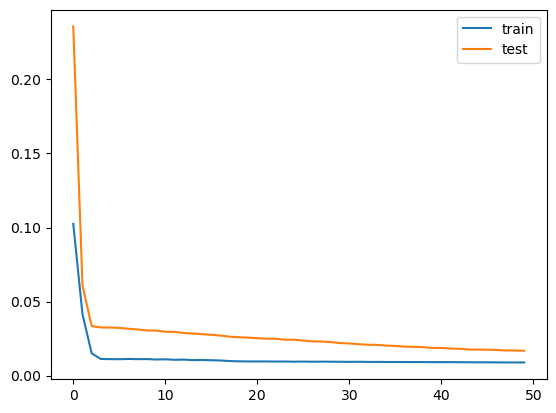

In [7]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# 做出预测
yhat = model.predict(test_X)
test_y = test_y.reshape((len(test_y), 1))
# 计算RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

450/450 [==============================] - 2s 3ms/step
Test RMSE: 0.022


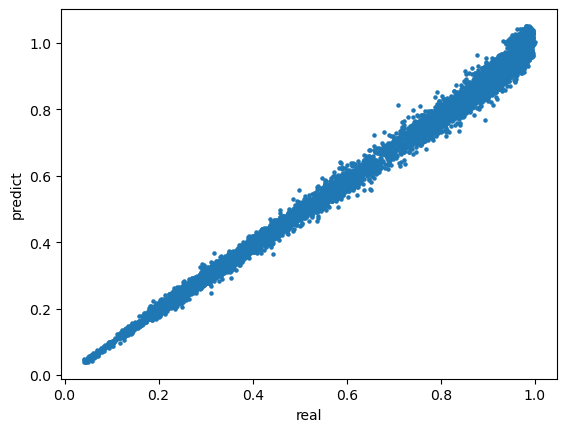

In [9]:
plt.scatter(test_y, yhat, s=5)
plt.xlabel('real')
plt.ylabel('predict')
plt.show()

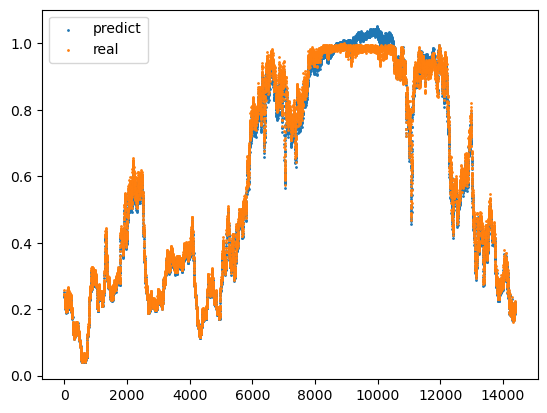

In [10]:
import numpy as np
t = np.arange(0, len(yhat), 1)
plt.scatter(t, yhat, s=1, label='predict')
plt.scatter(t, test_y, s=1, label='real')
plt.legend()

In [20]:
days_pre = 5*24*60*2
xpre = []
ypre = []
for i in range(days_pre):
    xhat = train_X[-1].reshape((1, 1, 2))
    yhat = model.predict(xhat)
    print(yhat)

1/1 [==============================] - 0s 34ms/step
[[0.25783417]]
